In [2]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
from lib.lib_lopt import *
from ot.lp.emd_wrap import emd_c, check_result, emd_1d_sorted

In [3]:
n=int(20)
a=np.ones(n)
b=np.ones(n)
X=np.random.rand(n)
Y=np.random.rand(n)
M=cost_matrix(X,Y)
numItermax=12
numThreads=1

#@torch.compile
def test2():
    G, cost, u, v, result_code = emd_c(a, b, M, numItermax, numThreads)
    result_code_string = check_result(result_code)
    return 0

#@nb.jit()
def test():
    G, cost, u, v, result_code = emd_c(a, b, M, numItermax, numThreads)
    result_code_string = check_result(result_code)
    return 0




In [4]:
%time test2()
%time test()

CPU times: user 109 µs, sys: 152 µs, total: 261 µs
Wall time: 269 µs
CPU times: user 113 µs, sys: 159 µs, total: 272 µs
Wall time: 174 µs


/tmp/ipykernel_2081240/1873500357.py:13: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 12. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/tmp/ipykernel_2081240/1873500357.py:19: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 12. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually 

0

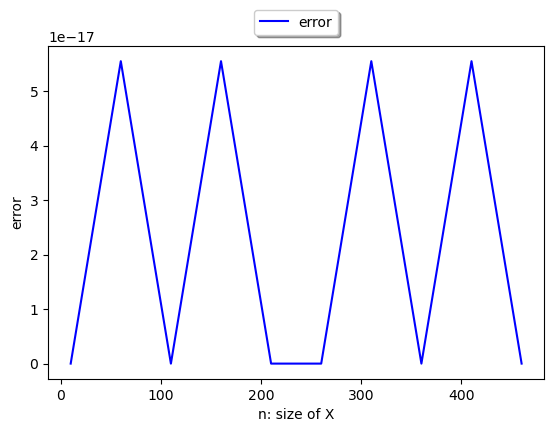

In [116]:
# test correctness
Lambda=0.2
step_size=50
k=1
n_list=np.array(range(10,500,step_size))

opt_cost1=np.zeros((n_list.shape[0],k))
opt_cost2=np.zeros((n_list.shape[0],k))

for i in range(n_list.shape[0]):
    n=n_list[i]
    for k_p in range(k):
        X0=np.random.uniform(-20,20,(n,2))+15
        X1=np.random.uniform(-20,20,(n,2))+0
        X2=np.random.uniform(-20,20,(n,2))+30

        p0=np.ones(n)/n
        p1=np.ones(n)/n
        p2=np.ones(n)/n
        cost1,gamma,penualty1=opt_lp(X0,X1,p0,p1,Lambda,numItermax=200000)
        opt_cost1[i,k_p]=cost1+penualty1
        U0=np.zeros((n,2))
        M0=0.0
        p0_hat=p0
        U1,p1_hat,M1,p1Perp=lopt_embedding(X0,X1,p0,p1,Lambda)
        cost2,penualty2=lopt(U1,U0,p1_hat,p0_hat,Lambda,M1,M0)
#        cost2=np.sum((U1.T)**2*p1_hat)
#        penualty2=Lambda*(np.sum(np.abs(p0-p1_hat))+M1)
        
        opt_cost2[i,k_p]=cost2+penualty2

#        Vi,p0_Ti=linear_embedding(Xi,X0,p1,p0,Lambda)
#        Vj,p0_Tj=linear_embedding(Xj,X0,p2,p0,Lambda)
#        Vij,p0_Tij=vector_plus(Vi,-Vj,p0_Ti,p0_Tj)
#        cost2,penualty2=vector_norm(Vij,p0_Tij,1,Lambda)
#        opt_cost2[i,k_p]=cost2+penualty2
        # if cost2+penualty2<cost1+penualty1-0.00001:
            #     print('error')
            #     print('cost2',cost2)
    #     print('cost1',cost1)
    #     print('penualty1',penualty1)
    #     print('penualty2',penualty2)
    #     break



fig = plt.figure()
ax = plt.subplot(111)
error=opt_cost2-opt_cost1
error_mean=error.mean(1)
error_std=error.std(1)

plt.plot(n_list,error_mean,'-',c='blue',label='error')
plt.fill_between(n_list,error_mean-1*error_std,error_mean+1*error_std,alpha=0.3)

plt.xlabel("n: size of X")
plt.ylabel("error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
#plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
plt.show()


In [145]:
K_list=np.array([2,5,10])
n_list=np.array([500]) # np.array(range(200,1050,step_size))

m_list=random_projections(2,K_list.max(),Type=0)*np.sqrt(2)
l=5

n_list=np.array([500]) # np.array(range(200,1050,step_size))

id2=np.eye(2)

Lambda_list=np.linspace(0.2,20,20)
#Lambda_list=np.array([0.5,1.0,5.0,10.0,20.0])
Lambda_N=Lambda_list.shape[0]
save_dict={}

    
for K in K_list:
    List_ij=[]
    for i in range(K):
        for j in range(i+1,K):
            List_ij.append((i,j))
    
    n_compute=len(List_ij)
    opt_cost_list=np.zeros((n_list.shape[0],Lambda_N,n_compute,l))
    lopt_cost_list=np.zeros((n_list.shape[0],Lambda_N,n_compute,l))
    
    for Lambda_i,Lambda in enumerate(Lambda_list):
        
        #save_dict['Lambda'+str(Lambda)]={}
        for epoch,n in enumerate(n_list):
            for l_p in range(l):
                #generate data
                X_list=list()
                p_list=list()
                mean_list=list()
                for i in range(K):
                    vi=m_list[i]
                    Xi=np.random.multivariate_normal(vi,id2,n)
                    X_list.append(Xi)    
                    p_list.append(np.ones(n)/n)
                    mean_list.append(vi)
                X_list=np.stack(X_list)
                p_list=np.stack(p_list)
                mean_list=np.stack(mean_list)
                
                m_bar=np.mean(mean_list,0)
                p0=np.ones(n)/n
                # compute reference
                X0=np.random.multivariate_normal(m_bar,id2,n)
               
                
                # compute OPT distance pairwisely 
                for (k,(i,j)) in enumerate(List_ij):
                    X1=X_list[i]
                    X2=X_list[j]
                    p1=p_list[i]
                    p2=p_list[j]          
                    cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=1000*n)
                    opt_cost_list[epoch,Lambda_i,k,l_p]=cost1+penualty1


                # compute lopt embedding
                lopt_embedding_list=[]
                for i in range(K):
                    Xi=X_list[i]
                    pi=p_list[i]
                    Ui,pi_hat,Mi,pi_perp=lopt_embedding(X0,Xi,p0,pi,Lambda,numItermax=1000*n)
                    lopt_embedding_list.append((Ui,pi_hat,Mi))
                    
                for (k,(i,j)) in enumerate(List_ij):
                    Ui,pi_hat,Mi=lopt_embedding_list[i]
                    Uj,pj_hat,Mj=lopt_embedding_list[j]
                    cost2,penualty2=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                    lopt_cost_list[epoch,Lambda_i,k,l_p]=cost2+penualty2

               
        save_dict['K=%d,opt_cost_list'%(K)]=opt_cost_list
        save_dict['K=%d,lopt_cost_list'%(K)]=lopt_cost_list
        #save_dict['K=%d,opt_cost3'%(K)]=opt_cost3
torch.save(save_dict,'experiment/performance/cost_list.pt')

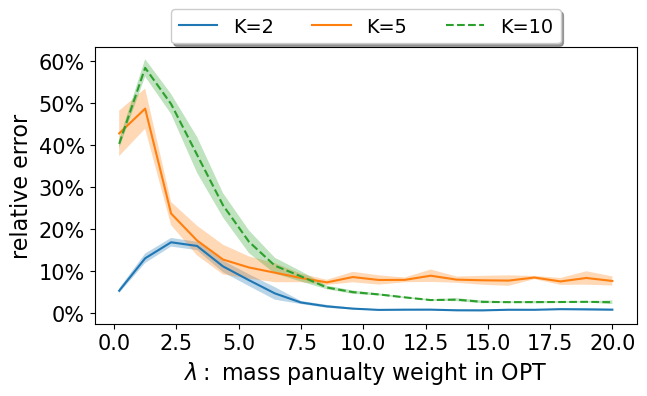

done


In [148]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '-', '--', '--', '-.', '-.']
#ax = plt.subplot(111)
#save_dict2=torch.load('experiment/performance/cost_list.pt')
#save_dict2=save_dict.copy()
fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)
ind=0
for K in K_list:
    opt_cost1=save_dict['K=%d,opt_cost_list'%(K)]
    opt_cost2=save_dict['K=%d,lopt_cost_list'%(K)]
    relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)[0]
    
    relative_error_mean=relative_error.mean(1)
    relative_error_std=relative_error.std(1)
    ax.plot(Lambda_list,relative_error_mean,linestyle_array[ind],label=r'K=%d'%(K))
    ax.fill_between(Lambda_list,relative_error_mean-1*relative_error_std,relative_error_mean+1*relative_error_std,alpha=0.3)
    ind+=1

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel("$\lambda:$ mass panualty weight in OPT",fontsize=16)
ax.set_ylabel("relative error",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.17),
          fancybox=True, shadow=True, ncol=3,fontsize=13.9)
plt.savefig('experiment/Rebuttal/error_lambda.pdf',format="pdf",dpi=800,bbox_inches='tight')
plt.show()
#plt.close()

print('done')

median nan
mean nan


/tmp/ipykernel_2081240/717925075.py:4: RuntimeWarning: invalid value encountered in divide
  relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1)[0,0,:,:]


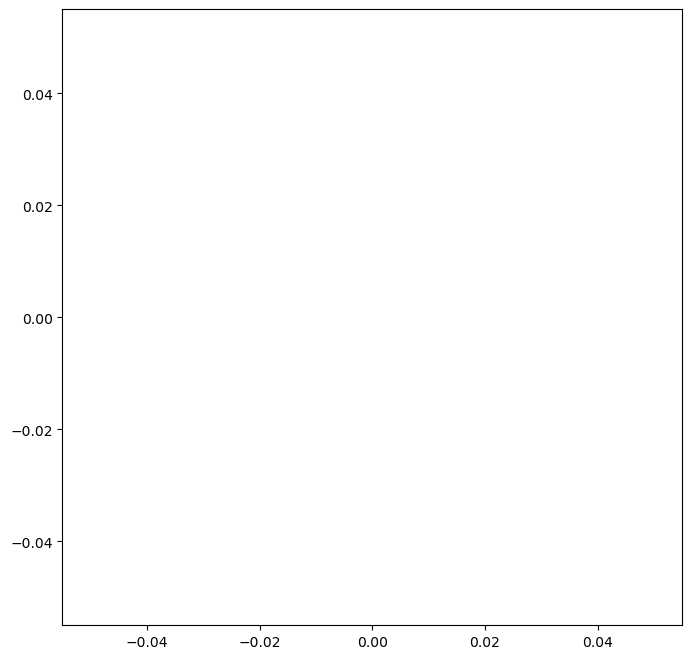

median nan
mean nan


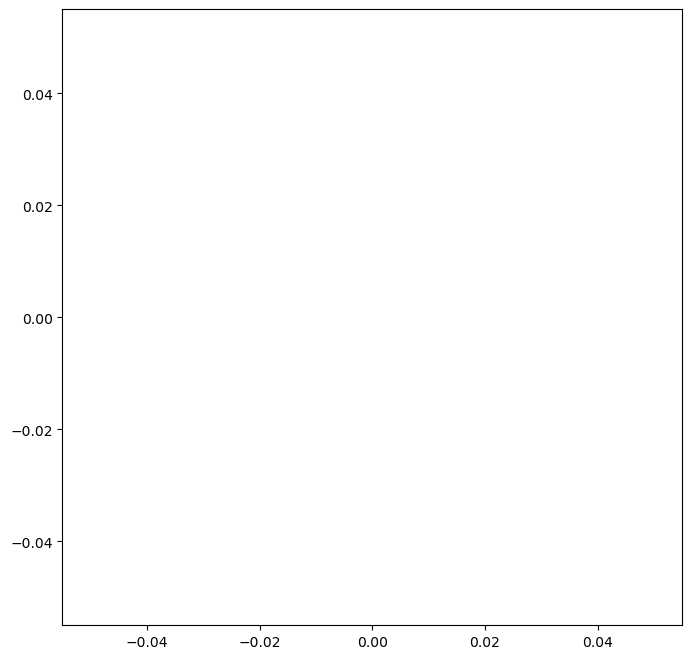

median nan
mean nan


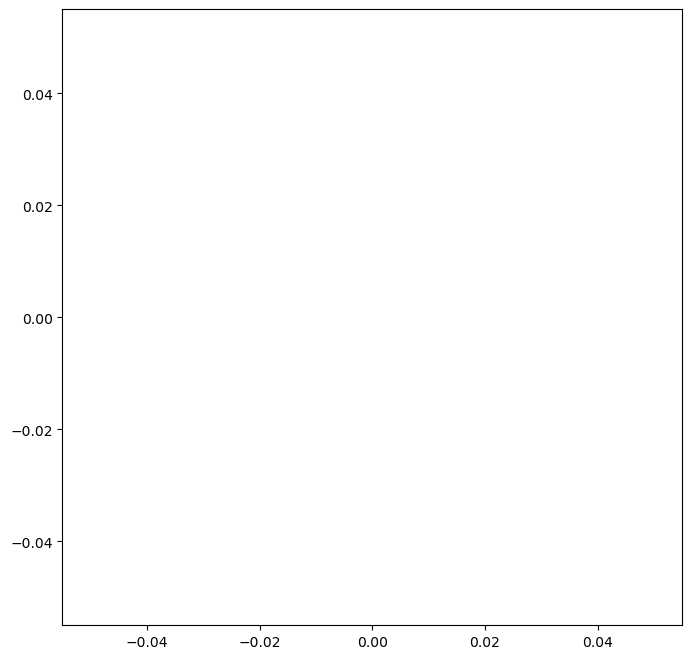

median nan
mean nan


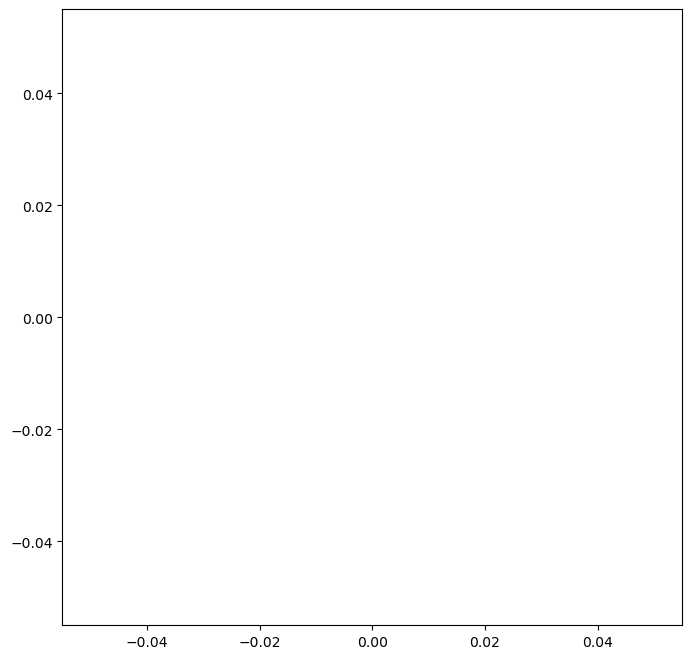

median nan
mean nan


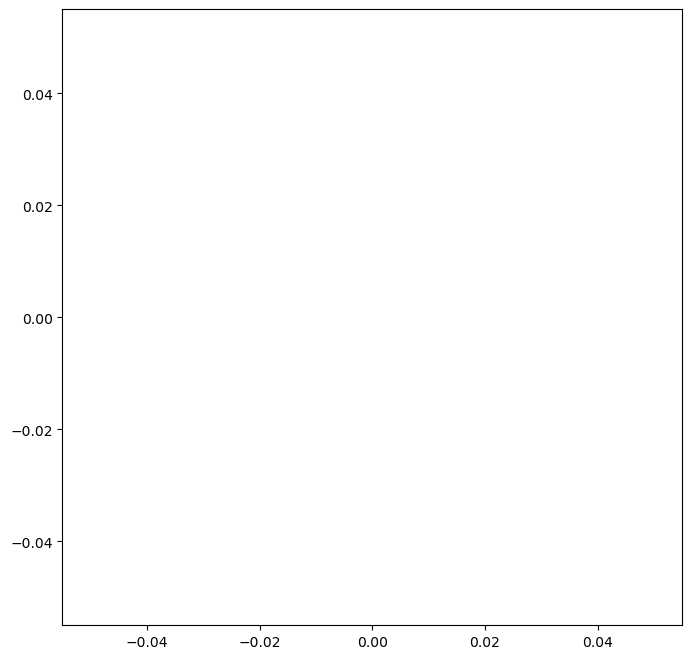

In [118]:
K=10
opt_cost1=save_dict['K=%d,opt_cost_list'%(K)]
opt_cost2=save_dict['K=%d,lopt_cost_list'%(K)]
relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1)[0,0,:,:]



for i in range(5):
    print('median',np.median(relative_error[:,i]))
    print('mean',relative_error[:,i].mean())
    fig,ax=plt.subplots(1,1,figsize=(8,8))
    ax.plot(relative_error[:,i])
    plt.show()
    

In [127]:
A=np.abs(opt_cost2-opt_cost1)

In [131]:
B=A[0]
print(B.shape)
B[:,0,0]

(5, 45, 5)


array([ 0.        , 55.53243696, 97.08008314, 14.86876141, 14.27397668])

In [114]:
Lambda_list

array([ 0.2       ,  1.22758621,  2.25517241,  3.28275862,  4.31034483,
        5.33793103,  6.36551724,  7.39310345,  8.42068966,  9.44827586,
       10.47586207, 11.50344828, 12.53103448, 13.55862069, 14.5862069 ,
       15.6137931 , 16.64137931, 17.66896552, 18.69655172, 19.72413793,
       20.75172414, 21.77931034, 22.80689655, 23.83448276, 24.86206897,
       25.88965517, 26.91724138, 27.94482759, 28.97241379, 30.        ])

K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


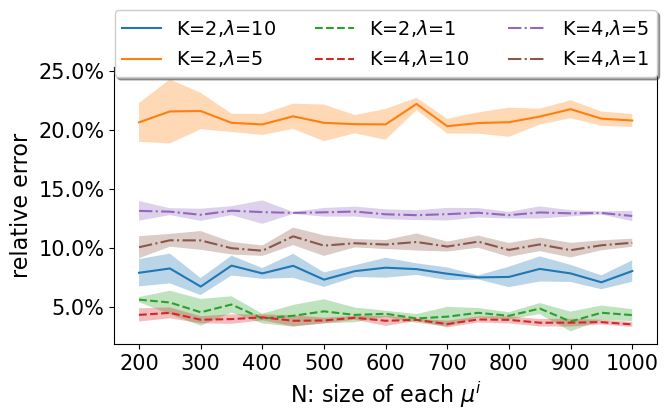

done
K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


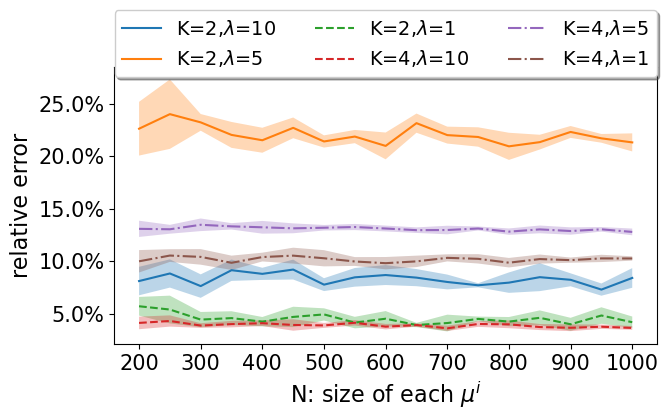

done


In [61]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '-', '--', '--', '-.', '-.']
Lambda=20.0
step_size=50

l=5
K_list=[2,4]
n_list=np.array(range(200,1050,step_size))

m_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

id2=np.eye(2)
Lambda_list=[10.0,5.0,1.0]
save_dict={}
#ax = plt.subplot(111)
save_dict2=torch.load('experiment/performance/cost_list.pt')
for x in [2,3]:
    fig = plt.figure(1, (7,4))
    ax = fig.add_subplot(1,1,1)
    ind=0
    for K in [2,4]:
        print('K,',K)
        for Lambda in Lambda_list:
            print('Lambda,',Lambda)
            opt_cost1=save_dict2['Lambda=%d,K=%d,opt_cost1'%(Lambda,K)]
            opt_cost2=save_dict2['Lambda=%d,K=%d,opt_cost%d'%(Lambda,K,x)]
            relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)
            relative_error_mean=relative_error.mean(1)
            relative_error_std=relative_error.std(1)

            #label=r'K=%d,$\lambda$=%d'%(K,Lambda)
            ax.plot(n_list,relative_error_mean,linestyle_array[ind],label=r'K=%d,$\lambda$=%d'%(K,Lambda))
            ax.fill_between(n_list,relative_error_mean-1*relative_error_std,relative_error_mean+1*relative_error_std,alpha=0.3)
            ind+=1
   
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xlabel("N: size of each $\mu^i$",fontsize=16)
    ax.set_ylabel("relative error",fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.24),
              fancybox=True, shadow=True, ncol=3,fontsize=13.9)
    plt.savefig('experiment/performance/error%d.pdf'%(x),format="pdf",dpi=800,bbox_inches='tight')
    plt.show()
    #plt.close()
    
    print('done')